In [178]:
#pip install yfinance

In [186]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

apple = yf.Ticker("AAPL")
alibaba = yf.Ticker("BABA")
mcd = yf.Ticker("MCD")
disney = yf.Ticker("DIS")
boeing = yf.Ticker("BA")

# get historical market data
hist_apple = apple.history(period="1y")
hist_baba = alibaba.history(period="1y")
hist_mcdonald = mcd.history(period="1y")
hist_disney = disney.history(period="1y")
hist_boeing = boeing.history(period="1y")

In [187]:
"""Так как рассчитываем справедливую стоимость, то возьмем рост рынка SP500 за последние 20 лет, которые равняется 10%
соответственно, и акции из индекса будут расти на 10%, и дисконтироваться по процентой ставке"""

#https://www.investopedia.com/ask/answers/042415/what-average-annual-return-sp-500.asp
sp500_rate = 1.1 #справедливый рост акций

#https://www.bloomberg.com/markets/rates-bonds/government-bonds/us
free_risk = 0.042 #5 годовая процентная ставка в США

In [188]:
"""Высчитываем справедливую стоимость акций на каждом году и берем стандартное отклонение"""

def fair_price(hist_stock):

    std = hist_stock['Close'].std()
    price = hist_stock['Close'].tail(1)
    years = np.linspace(1, 5, 5)
    future_price = np.zeros(5)
    init_price = price
    
    for j in range(5):
        price = price*sp500_rate
        future_price[j] = price*(1/(1+free_risk)**years[j])
    
    all_prices = np.concatenate((init_price,future_price))
    
    return std, all_prices 

In [189]:
std_apple, price_apple = fair_price(hist_apple)
std_baba, price_baba = fair_price(hist_baba)
std_mcd, price_mcd = fair_price(hist_mcdonald)
std_dsn, price_dsn = fair_price(hist_disney)
std_bng, price_bng = fair_price(hist_boeing)


In [190]:
np.random.seed(0)

"""Методом монте-карло со стандартным отклонением у каждоый акции смотрит распределение цен
купонный доход рассчитываем как разницу у каждой акции между каждым годом, затем берем среднее значение купонов за 5 лет"""

def monte_carlo(std, mean_price):
    
    samples = 10000
    monte_carlo = np.zeros((6,samples))
    monte_carlo[0,] = np.random.normal(mean_price[0], 0, samples)
    
    row = np.linspace(1, 5, 5, dtype = 'int')
    for j in row:
        monte_carlo[j] = np.random.normal(mean_price[j], std, samples)
    
    mn_price = monte_carlo[5] - monte_carlo[0]
    
    fair_payoff = np.zeros((5,samples))
    for j in range(5):
        fair_payoff[j,] = monte_carlo[j+1,] - monte_carlo[j,]

    
    fair_payoff = fair_payoff.T    
    for i in range(samples):
        fair_payoff[i,] = fair_payoff[i,].mean()
    
    payoff = fair_payoff.T[0]
    
    return payoff, mn_price

Справедливая стоимость опциона: [12.83247863  5.99559083  6.90265862 ... 13.50194954 13.39497031
 12.76664218]


Text(0.5, 0, 'Распределений доходностей от 5 купонов')

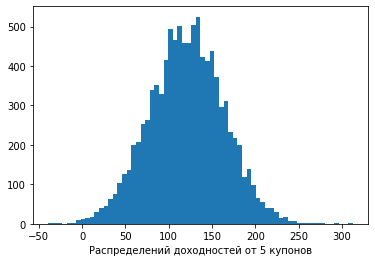

In [191]:
"""ТК купоны мы считали по отдельности, то скорректируем его на всю корзину, справедливая стоимость самого опциона 
это доходность акции за 5 лет по справедливой стоимости акции 
те доходность акций идет по индексу SP500 и дисконтируется на безрисковую ставку, затем это все нужно будет скорректировать на вероятность,
что корзина пойдет вверх или вниз"""

payoff_apple, appl_price = monte_carlo(std_apple, price_apple)
payoff_baba, baba_price  = monte_carlo(std_baba, price_baba)
payoff_dsn, dsn_price  = monte_carlo(std_dsn, price_dsn)
payoff_mcd, mcd_price  = monte_carlo(std_mcd, price_mcd)
payoff_bng, bng_price  = monte_carlo(std_bng, price_bng)

p = 1/2 #есть два исхода по каждый акции вверх или вниз пойдет, соотвественно цену купона скорректируем поделив на 2

adj_payoff_appl = payoff_apple*p
adj_payoff_baba = payoff_baba*p
adj_patoff_dsn = payoff_dsn*p
adj_patoff_mcd = payoff_mcd*p
adj_patoff_bng = payoff_bng*p

p_basket = 1/2**5 #вероятность, что пойдет вся корзина вверх или вниз из 5 акций

adj_price_option = (appl_price + baba_price + dsn_price + mcd_price + bng_price)*p_basket
overall_coupon_income = (adj_payoff_appl + adj_payoff_baba + adj_patoff_dsn + adj_patoff_bng)*5

print("Справедливая стоимость опциона:", adj_price_option)

plt.hist(overall_coupon_income, bins ='auto') 
plt.xlabel('Распределений доходностей от 5 купонов')

Справедливая стоимость опциона
9.597263784150298


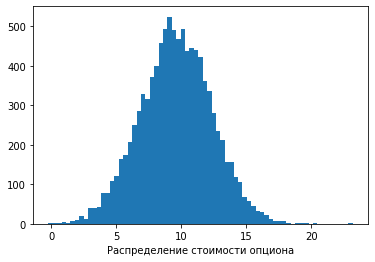

In [193]:
plt.hist(adj_price_option, bins ='auto') 
plt.xlabel('Распределение стоимости опциона')
print("Справедливая стоимость опциона") #Это мат ожидание - то есть доходность акций за 5 лет по справедливым ценам акций
print(adj_price_option.mean())

Text(0.5, 0, 'Распределение доходности')

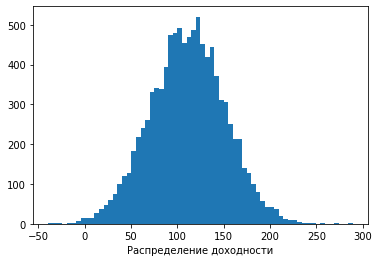

In [195]:
plt.hist(overall_coupon_income - adj_price_option, bins ='auto') 
plt.xlabel('Распределение доходности')